In [1]:
import pandas as pd
import numpy as np
import pylab as pl

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
%matplotlib inline

In [2]:
# Load the cleaned data into dataframe

""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    
"""
warnings.simplefilter('ignore')
data = pd.read_csv('../data/final_wine_and_fire_data.csv')
data.dropna(inplace = True)
print(data.shape)
data.head()

(9757, 35)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,country,description,designation,points,price,...,total_fires_current,sum_fire_size_current,norm_vintage,norm_variety_numerical,norm_price,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current
0,0,0,0,10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,...,202,1756.38,0.009921,0.113960,0.006955,0.070707,0.000000,0.000000,0.450893,0.006877
1,1,3,3,23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,...,192,639.14,0.009921,0.464387,0.008445,0.070707,0.008929,0.000310,0.428571,0.002502
2,2,4,4,25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,...,202,1756.38,0.009921,0.626781,0.031793,0.070707,0.000000,0.000000,0.450893,0.006877
3,3,12,12,60,60,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,...,247,1453.08,0.010913,0.113960,0.047193,0.060606,0.272321,0.005246,0.551339,0.005689
4,4,13,13,63,64,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,...,109,2711.55,0.011905,0.732194,0.010432,0.060606,0.183036,0.002815,0.243304,0.010616


In [3]:
#from  https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#used to plot the confusion matrix nicely

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax


In [4]:
def model_stats(y_true, y_pred):
    try:
        plot_confusion_matrix(y_true, y_pred, unique_labels(y_true))
    except:
        conf_mat = confusion_matrix(y_true, y_pred)
        print('confusion matrix')
        print(conf_mat)
    
    stats = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    print('\nprecision')
    print(stats[0])
    print('recall')
    print(stats[1])
    print('f1 score')
    print(stats[2])
    print('\n')

In [5]:
x = data.loc[:, ['norm_vintage', 'norm_price', 'norm_variety_numerical']]
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)
model_stats(y_test, predict)

print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y ,cv = 5))

confusion matrix
[[  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   0   3   0   2   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   1  10   0   5   0   0   1   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   2  21   0   5   1   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   6  36   0  10   0   2   2   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   7  68   0  29   1   5   3   0   0   0   0
    0]
 [  0   0   5   0   0   0   0  12  85   0  22   3   3   2   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   5 136   0  67   3   6   8   0   0   0   0
    0]
 [  0   0   6   0   0   0   0   8  86   0  34   1   4   6   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   5 181   0 111  14   7  21   0   0   0   0
    0]
 [  0   0   2   0   0   0   0   4 120   0 102   9  14  21   0   0   0   0
    0]
 [  0   0  

In [6]:
x = data.loc[:, ['norm_total_fires', 'norm_sum_fire_size']]
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

confusion matrix
[[  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   0   0  12   2   0   0   0   0   0   0
    2]
 [  0   1   0   0   0   0   0   0   0   0  25   2   0   0   0   0   0   0
    2]
 [  0   1   0   0   0   2   0   0   0   0  38   3   0   2   0   0   0   0
   10]
 [  0   0   0   0   0   3   0   0   0   0  98   2   0   2   0   0   0   0
    9]
 [  0   0   0   0   0   4   0   0   1   0 106   7   0   2   0   0   0   0
   12]
 [  0   2   0   0   0   2   0   0   0   0 190   4   0   5   0   0   0   0
   23]
 [  0   0   0   0   0   0   0   0   0   0 127   1   0   6   0   0   0   0
   11]
 [  0   1   0   0   0   2   0   0   4   0 263   5   0   7   0   0   0   0
   58]
 [  0   0   0   0   0   7   0   0   1   0 215   1   0   9   0   0   0   0
   39]
 [  0   0  

In [7]:
x = data.loc[:, 'points']
x = np.array(x, dtype=pd.Series)
x = x.reshape(-1, 1)
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.33, random_state=0)

n_bayes = MultinomialNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)
model_stats(y_test, predict)

print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y ,cv = 5))

confusion matrix
[[  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  10   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  44   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  89   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 200   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 236   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 386   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 223   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 554   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 445   0   0   0   0   0   0   0
    0]
 [  0   0  

In [8]:
points = data.loc[:,'points']
points = np.array(points, dtype=pd.Series)
points = points.reshape(-1, 1)
cluster = KMeans(n_clusters = 3, random_state = 0).fit(points)
point_bins = cluster.labels_

data['point_bin'] = point_bins

Confusion matrix, without normalization
[[398 172  41]
 [155 329 100]
 [313 373  71]]


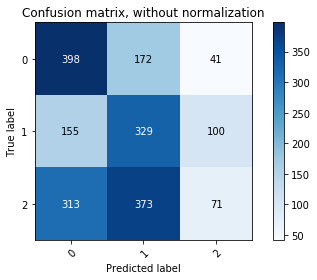


precision
0.38635493329876924
recall
0.4088114754098361
f1 score
0.3605432143414068


5 fold cross validation accuracies
[0.41137295 0.4272541  0.40829918 0.41209636 0.41230769]


In [17]:
x = data.loc[:, ['norm_price', 'norm_total_fires', 'norm_sum_fire_size']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

Confusion matrix, without normalization
[[307 290  14]
 [ 86 486  12]
 [200 543  14]]


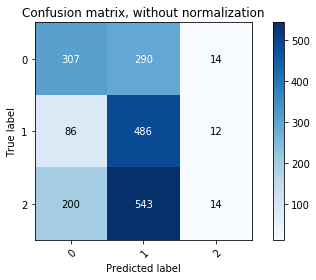


precision
0.40801737513232206
recall
0.413422131147541
f1 score
0.32606329432398085


5 fold cross validation accuracies
[0.42520492 0.43852459 0.40932377 0.42029728 0.40615385]


In [18]:
x = data.loc[:, ['norm_price', 'norm_total_fires_current', 'norm_sum_fire_size_current']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))